In [1]:
!pip install networkx
!pip install ortools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 21.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.6.6 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.26.1 which is incompatible.
google-cloud-datastore 2.19.0 requires protobuf!=3.20.0,!=3.20.1,!=4.2

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm
import warnings
import networkx as nx
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [15]:
class PositionalEncoding(nn.Module):
    """
    Adds positional information to node embeddings.
    """
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (batch_size, seq_length, d_model)
        Returns:
            Tensor of shape (batch_size, seq_length, d_model)
        """
        x = x + self.pe[:, :x.size(1)]
        return x

class TransformerModel(nn.Module):
    """
    Transformer model that predicts pheromone matrix given node coordinates.
    """
    def __init__(self, num_nodes, d_model=128, nhead=8, num_layers=8, dropout=0.1, learnable_pos=False):
        super(TransformerModel, self).__init__()
        self.d_model = d_model
        self.input_projection = nn.Linear(2, d_model)

        # Use learnable positional encoding if specified
        if learnable_pos:
            self.pos_encoder = nn.Parameter(torch.zeros(1, num_nodes, d_model))
            nn.init.uniform_(self.pos_encoder, -0.02, 0.02)
        else:
            self.pos_encoder = PositionalEncoding(d_model)

        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=512, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.output_projection = nn.Linear(d_model, d_model)
        self.final_activation = nn.ReLU()

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (batch_size, num_nodes, 2)  # Node coordinates
        Returns:
            pheromone_matrix: Tensor of shape (batch_size, num_nodes, num_nodes)
        """
        x = self.input_projection(x)
        x = x * np.sqrt(self.d_model)

        # Apply positional encoding
        if isinstance(self.pos_encoder, nn.Parameter):
            x = x + self.pos_encoder[:, :x.size(1)]
        else:
            x = self.pos_encoder(x)

        x = self.transformer_encoder(x)
        x = self.output_projection(x)
        pheromone_matrix = torch.matmul(x, x.transpose(1, 2))
        pheromone_matrix = self.final_activation(pheromone_matrix)
        return pheromone_matrix



In [16]:
class StandardAntColonyOptimizer:
    """
    Implements the standard Ant Colony Optimization algorithm for TSP.
    Used for generating synthetic data and serving as a baseline.
    """
    def __init__(self, num_nodes, distance_matrix, num_ants=10, alpha=1.0, beta=2.0, evaporation_rate=0.5, Q=100):
        self.num_nodes = num_nodes
        self.distance_matrix = distance_matrix
        self.num_ants = num_ants
        self.alpha = alpha
        self.beta = beta
        self.evaporation_rate = evaporation_rate
        self.Q = Q
        self.pheromone = np.ones((num_nodes, num_nodes))
        self.best_distance = float('inf')
        self.best_solution = None

    def optimize(self, iterations=50):
        """
        Runs the ACO algorithm for a specified number of iterations.
        """
        for iteration in range(iterations):
            all_solutions = []
            all_distances = []
            for _ in range(self.num_ants):
                solution = self.construct_solution()
                distance = self.calculate_total_distance(solution)
                all_solutions.append(solution)
                all_distances.append(distance)
                if distance < self.best_distance:
                    self.best_distance = distance
                    self.best_solution = solution
            self.update_pheromone(all_solutions, all_distances)
        return self.best_solution, self.best_distance

    def construct_solution(self):
        """
        Constructs a solution (tour) by probabilistically selecting the next node based on pheromone and heuristic.
        """
        solution = []
        visited = set()
        current_node = np.random.randint(0, self.num_nodes)
        solution.append(current_node)
        visited.add(current_node)

        for _ in range(self.num_nodes - 1):
            probabilities = self.calculate_transition_probabilities(current_node, visited)
            next_node = np.random.choice(range(self.num_nodes), p=probabilities)
            solution.append(next_node)
            visited.add(next_node)
            current_node = next_node
        return solution

    def calculate_transition_probabilities(self, current_node, visited):
        """
        Calculates the probability of moving to each node not yet visited.
        """
        pheromone = self.pheromone[current_node] ** self.alpha
        heuristic = (1.0 / (self.distance_matrix[current_node] + 1e-10)) ** self.beta
        pheromone[list(visited)] = 0
        heuristic[list(visited)] = 0

        numerator = pheromone * heuristic
        denominator = np.sum(numerator)
        if denominator == 0:
            probabilities = np.ones(self.num_nodes) / self.num_nodes
        else:
            probabilities = numerator / denominator
        return probabilities

    def update_pheromone(self, solutions, distances):
        """
        Updates pheromone levels based on the solutions found by ants.
        """
        self.pheromone *= (1 - self.evaporation_rate)

        for solution, distance in zip(solutions, distances):
            pheromone_increment = self.Q / distance
            for i in range(len(solution) - 1):
                from_node = solution[i]
                to_node = solution[i + 1]
                self.pheromone[from_node][to_node] += pheromone_increment
            from_node = solution[-1]
            to_node = solution[0]
            self.pheromone[from_node][to_node] += pheromone_increment

    def calculate_total_distance(self, solution):
        """
        Calculates the total distance of the tour.
        """
        distance = 0.0
        for i in range(len(solution) - 1):
            distance += self.distance_matrix[solution[i]][solution[i + 1]]
        distance += self.distance_matrix[solution[-1]][solution[0]]
        return distance

class ImprovedAntColonyOptimizer:
    """
    Enhanced ACO algorithm where the initial pheromone matrix is predicted by the Transformer model.
    """
    def __init__(self, num_nodes, distance_matrix, initial_pheromone=None, num_ants=10, alpha=1.0, beta=2.0, evaporation_rate=0.5, Q=100):
        self.num_nodes = num_nodes
        self.distance_matrix = distance_matrix
        self.num_ants = num_ants
        self.alpha = alpha
        self.beta = beta
        self.evaporation_rate = evaporation_rate
        self.Q = Q
        if initial_pheromone is not None:
            self.pheromone = initial_pheromone  # Use the provided initial pheromone matrix
        else:
            self.pheromone = np.ones((num_nodes, num_nodes))  # Initialize pheromone levels uniformly
        self.best_distance = float('inf')
        self.best_solution = None

    def optimize(self, iterations=50):
        """
        Runs the ImprovedACO algorithm for a specified number of iterations.
        """
        for iteration in range(iterations):
            all_solutions = []
            all_distances = []
            for _ in range(self.num_ants):
                solution = self.construct_solution()
                distance = self.calculate_total_distance(solution)
                all_solutions.append(solution)
                all_distances.append(distance)
                if distance < self.best_distance:
                    self.best_distance = distance
                    self.best_solution = solution
            self.update_pheromone(all_solutions, all_distances)
        return self.best_solution, self.best_distance

    def construct_solution(self):
        """
        Constructs a solution (tour) by probabilistically selecting the next node based on pheromone and heuristic.
        """
        solution = []
        visited = set()
        current_node = np.random.randint(0, self.num_nodes)
        solution.append(current_node)
        visited.add(current_node)

        for _ in range(self.num_nodes - 1):
            probabilities = self.calculate_transition_probabilities(current_node, visited)
            next_node = np.random.choice(range(self.num_nodes), p=probabilities)
            solution.append(next_node)
            visited.add(next_node)
            current_node = next_node
        return solution

    def calculate_transition_probabilities(self, current_node, visited):
        """
        Calculates the probability of moving to each node not yet visited.
        """
        pheromone = self.pheromone[current_node] ** self.alpha
        heuristic = (1.0 / (self.distance_matrix[current_node] + 1e-10)) ** self.beta
        pheromone[list(visited)] = 0
        heuristic[list(visited)] = 0

        numerator = pheromone * heuristic
        denominator = np.sum(numerator)
        if denominator == 0:
            probabilities = np.ones(self.num_nodes) / self.num_nodes
        else:
            probabilities = numerator / denominator
        return probabilities

    def update_pheromone(self, solutions, distances):
        """
        Updates pheromone levels based on the solutions found by ants.
        """
        self.pheromone *= (1 - self.evaporation_rate)

        for solution, distance in zip(solutions, distances):
            pheromone_increment = self.Q / distance
            for i in range(len(solution) - 1):
                from_node = solution[i]
                to_node = solution[i + 1]
                self.pheromone[from_node][to_node] += pheromone_increment
            from_node = solution[-1]
            to_node = solution[0]
            self.pheromone[from_node][to_node] += pheromone_increment

    def calculate_total_distance(self, solution):
        """
        Calculates the total distance of the tour.
        """
        distance = 0.0
        for i in range(len(solution) - 1):
            distance += self.distance_matrix[solution[i]][solution[i + 1]]
        distance += self.distance_matrix[solution[-1]][solution[0]]
        return distance

In [17]:
import numpy as np
from tqdm import tqdm
from scipy.spatial.distance import cdist
from joblib import Parallel, delayed

def generate_tsp_solutions(num_nodes, num_samples=100, num_ants=50, iterations=100, n_jobs=-1):
    """
    Generates TSP solutions and pheromone matrices for randomly generated node coordinates.
    Utilizes parallel processing to speed up computation.

    Parameters:
    - num_nodes: Number of nodes in the TSP problem.
    - num_samples: Number of random TSP instances to generate.
    - num_ants: Number of ants in the ACO algorithm.
    - iterations: Number of iterations for the ACO algorithm.
    - n_jobs: Number of parallel jobs. -1 means using all processors.

    Returns:
    - coordinates_list: Array of node coordinates for each sample.
    - pheromone_matrices: Array of pheromone matrices for each sample.
    """
    def process_sample(_):
        # Generate random coordinates for nodes
        coordinates = np.random.rand(num_nodes, 2)

        # Compute Euclidean distance matrix using scipy for efficiency
        distance_matrix = cdist(coordinates, coordinates, metric='euclidean')

        try:
            # Initialize and run the ACO optimizer
            standard_aco = StandardAntColonyOptimizer(
                num_nodes=num_nodes,
                distance_matrix=distance_matrix,
                num_ants=num_ants,
                alpha=1.0,
                beta=2.0,
                evaporation_rate=0.3,
                Q=100
            )
            standard_aco.optimize(iterations=iterations)

            # Get and normalize the pheromone matrix
            pheromone_matrix = standard_aco.pheromone.copy()
            pheromone_matrix -= pheromone_matrix.min()
            max_val = pheromone_matrix.max()
            pheromone_matrix /= max_val if max_val > 0 else 1

            return coordinates, pheromone_matrix
        except Exception as e:
            print(f"Error processing sample: {e}")
            return None, None

    # Use parallel processing to handle multiple samples concurrently
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_sample)(i) for i in tqdm(range(num_samples), desc="Generating TSP Solutions")
    )

    # Filter out any None results from failed samples
    results = [res for res in results if res[0] is not None]

    # Unpack the results
    coordinates_list, pheromone_matrices = zip(*results)

    return np.array(coordinates_list), np.array(pheromone_matrices)

# Example usage:
# coordinates, pheromones = generate_tsp_solutions(num_nodes=50, num_samples=100, n_jobs=-1)


In [32]:
def run_experiment(node_sizes, num_trials=50, iterations=100, num_ants=50, alpha=1.0, beta=2.0, evaporation_rate=0.3, Q=100):
    """
    Runs experiments comparing StandardACO and ImprovedACO across multiple node sizes.
    Prints comparisons for each trial and plots the results.
    """
    results = {}

    for num_nodes in node_sizes:
        print(f"\n=== Node Size: {num_nodes} ===")

        print("Generating synthetic data for training...")
        coordinates_list, pheromone_matrices = generate_tsp_solutions(
            num_nodes=num_nodes,
            num_samples=500
        )

        split_index = int(0.8 * len(coordinates_list))
        train_coords = coordinates_list[:split_index]
        val_coords = coordinates_list[split_index:]
        train_pheromones = pheromone_matrices[:split_index]
        val_pheromones = pheromone_matrices[split_index:]

        train_coords_tensor = torch.tensor(train_coords, dtype=torch.float).to(device)
        train_pheromone_tensors = torch.tensor(train_pheromones, dtype=torch.float).to(device)
        val_coords_tensor = torch.tensor(val_coords, dtype=torch.float).to(device)
        val_pheromone_tensors = torch.tensor(val_pheromones, dtype=torch.float).to(device)

        model = TransformerModel(num_nodes=num_nodes, d_model=128, nhead=8, num_layers=6, dropout=0.1, learnable_pos=True).to(device)
        criterion = nn.MSELoss()
        optimizer_model = optim.Adam(model.parameters(), lr=0.001)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_model, 'min', patience=5, factor=0.5)

        print("Training Transformer Model...")
        epochs = 50
        batch_size = 32
        num_samples = train_coords_tensor.size(0)
        best_val_loss = float('inf')
        patience = 10
        patience_counter = 0

        for epoch in range(epochs):
            # Training
            model.train()
            permutation = torch.randperm(num_samples)
            train_loss = 0.0
            for i in range(0, num_samples, batch_size):
                indices = permutation[i:i+batch_size]
                input_batch = train_coords_tensor[indices]
                target_batch = train_pheromone_tensors[indices]

                optimizer_model.zero_grad()
                output = model(input_batch)
                loss = criterion(output, target_batch)
                loss.backward()
                optimizer_model.step()

                train_loss += loss.item()

            avg_train_loss = train_loss / (num_samples / batch_size)

            model.eval()
            with torch.no_grad():
                val_output = model(val_coords_tensor)
                val_loss = criterion(val_output, val_pheromone_tensors).item()

            scheduler.step(val_loss)

            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Save the best model
                torch.save(model.state_dict(), f'best_model_{num_nodes}.pth')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered.")
                    break

        model.load_state_dict(torch.load(f'best_model_{num_nodes}.pth'))

        results[num_nodes] = {'StandardACO': [], 'ImprovedACO': []}

        print(f"Running {num_trials} trials for node size {num_nodes}...")
        for trial in tqdm(range(num_trials), desc=f"Trials for node size {num_nodes}"):
            trial_number = trial + 1
            coordinates = np.random.rand(num_nodes, 2)
            distance_matrix = np.sqrt(
                (coordinates[:, np.newaxis, 0] - coordinates[np.newaxis, :, 0]) ** 2 +
                (coordinates[:, np.newaxis, 1] - coordinates[np.newaxis, :, 1]) ** 2
            )

            coordinates_input = torch.tensor(coordinates[np.newaxis, :, :], dtype=torch.float).to(device)
            with torch.no_grad():
                model.eval()
                predicted_pheromone = model(coordinates_input)
            predicted_pheromone_np = predicted_pheromone.cpu().numpy()[0]

            predicted_pheromone_np -= predicted_pheromone_np.min()
            predicted_pheromone_np /= predicted_pheromone_np.max() if predicted_pheromone_np.max() > 0 else 1
            predicted_pheromone_np += 1e-6

            standard_aco = StandardAntColonyOptimizer(
                num_nodes=num_nodes,
                distance_matrix=distance_matrix,
                num_ants=num_ants,
                alpha=alpha,
                beta=beta,
                evaporation_rate=evaporation_rate,
                Q=Q
            )
            improved_aco = ImprovedAntColonyOptimizer(
                num_nodes=num_nodes,
                distance_matrix=distance_matrix,
                initial_pheromone=predicted_pheromone_np,
                num_ants=num_ants,
                alpha=alpha,
                beta=beta,
                evaporation_rate=evaporation_rate,
                Q=Q
            )

            _, best_distance_standard = standard_aco.optimize(iterations=iterations)
            _, best_distance_improved = improved_aco.optimize(iterations=iterations)

            results[num_nodes]['StandardACO'].append(best_distance_standard)
            results[num_nodes]['ImprovedACO'].append(best_distance_improved)

            print(f"Trial {trial_number}: StandardACO Best Distance = {best_distance_standard:.4f}, ImprovedACO Best Distance = {best_distance_improved:.4f}")

        # Plotting results for this node size
        plt.figure(figsize=(10, 6))
        plt.plot(results[num_nodes]['StandardACO'], label='StandardACO', marker='o')
        plt.plot(results[num_nodes]['ImprovedACO'], label='ImprovedACO', marker='s')
        plt.title(f"Best Distances for Node Size: {num_nodes}")
        plt.xlabel("Trial")
        plt.ylabel("Best Distance")
        plt.legend()
        plt.grid(True)
        plt.show()

        del model

    return results


In [33]:
def perform_statistical_tests(results):
    """
    Performs Wilcoxon signed-rank tests for each node size.
    Returns a dictionary of p-values.
    """
    node_sizes = sorted(results.keys())
    p_values = {}

    for num_nodes in node_sizes:
        standard = results[num_nodes]['StandardACO']
        improved = results[num_nodes]['ImprovedACO']
        stat, p = stats.wilcoxon(standard, improved)
        p_values[num_nodes] = p
        print(f"Node Size {num_nodes}: p-value = {p:.4e}")

    return p_values

In [34]:
def plot_results(results, p_values):
    """
    Plots average best distances for StandardACO and ImprovedACO across node sizes.
    Annotates significance based on p-values.
    """
    node_sizes = sorted(results.keys())
    standard_means = [np.mean(results[size]['StandardACO']) for size in node_sizes]
    improved_means = [np.mean(results[size]['ImprovedACO']) for size in node_sizes]
    standard_stds = [np.std(results[size]['StandardACO']) for size in node_sizes]
    improved_stds = [np.std(results[size]['ImprovedACO']) for size in node_sizes]

    x = np.arange(len(node_sizes))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, standard_means, width, yerr=standard_stds, label='Standard ACO', capsize=5, color='skyblue')
    rects2 = ax.bar(x + width/2, improved_means, width, yerr=improved_stds, label='ImprovedACO (Transformer)', capsize=5, color='salmon')

    ax.set_ylabel('Average Best Distance')
    ax.set_xlabel('Number of Nodes')
    ax.set_title('Comparison of StandardACO vs. ImprovedACO Across Different Node Sizes')
    ax.set_xticks(x)
    ax.set_xticklabels(node_sizes)
    ax.legend()

    for i, size in enumerate(node_sizes):
        p = p_values[size]
        if p < 0.001:
            significance = '***'
        elif p < 0.01:
            significance = '**'
        elif p < 0.05:
            significance = '*'
        else:
            significance = 'ns'
        ax.text(x[i], max(standard_means[i], improved_means[i]) + max(standard_stds[i], improved_stds[i]) + 0.05, significance, ha='center', va='bottom', color='black', fontsize=12)

    plt.tight_layout()
    plt.show()


=== Node Size: 30 ===
Generating synthetic data for training...


Generating TSP Solutions: 100%|██████████| 500/500 [09:31<00:00,  1.14s/it]


Training Transformer Model...
Epoch 1/50, Train Loss: 263.5825, Val Loss: 7.8829
Epoch 2/50, Train Loss: 4.5650, Val Loss: 1.6364
Epoch 3/50, Train Loss: 1.1278, Val Loss: 0.2654
Epoch 4/50, Train Loss: 0.4069, Val Loss: 0.0605
Epoch 5/50, Train Loss: 0.2662, Val Loss: 0.0263
Epoch 6/50, Train Loss: 0.2225, Val Loss: 0.0202
Epoch 7/50, Train Loss: 0.2001, Val Loss: 0.0192
Epoch 8/50, Train Loss: 0.1853, Val Loss: 0.0190
Epoch 9/50, Train Loss: 0.1680, Val Loss: 0.0190
Epoch 10/50, Train Loss: 0.1573, Val Loss: 0.0192
Epoch 11/50, Train Loss: 0.1472, Val Loss: 0.0194
Epoch 12/50, Train Loss: 0.1379, Val Loss: 0.0194
Epoch 13/50, Train Loss: 0.1323, Val Loss: 0.0193
Epoch 14/50, Train Loss: 0.1271, Val Loss: 0.0195
Epoch 15/50, Train Loss: 0.1252, Val Loss: 0.0194
Epoch 16/50, Train Loss: 0.1225, Val Loss: 0.0194
Epoch 17/50, Train Loss: 0.1198, Val Loss: 0.0196


<ipython-input-32-0f9572364df2>:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_{num_nodes}.pth'))


Epoch 18/50, Train Loss: 0.1206, Val Loss: 0.0193
Early stopping triggered.
Running 30 trials for node size 30...


Trials for node size 30:   3%|▎         | 1/30 [00:03<01:29,  3.09s/it]

Trial 1: StandardACO Best Distance = 4.6489, ImprovedACO Best Distance = 4.5082


Trials for node size 30:   7%|▋         | 2/30 [00:06<01:26,  3.08s/it]

Trial 2: StandardACO Best Distance = 4.9910, ImprovedACO Best Distance = 4.7393


Trials for node size 30:  10%|█         | 3/30 [00:09<01:23,  3.09s/it]

Trial 3: StandardACO Best Distance = 4.7712, ImprovedACO Best Distance = 4.8517


Trials for node size 30:  13%|█▎        | 4/30 [00:12<01:20,  3.09s/it]

Trial 4: StandardACO Best Distance = 4.5246, ImprovedACO Best Distance = 4.4182


Trials for node size 30:  17%|█▋        | 5/30 [00:15<01:17,  3.11s/it]

Trial 5: StandardACO Best Distance = 4.5338, ImprovedACO Best Distance = 4.5924


Trials for node size 30:  20%|██        | 6/30 [00:18<01:14,  3.10s/it]

Trial 6: StandardACO Best Distance = 4.6148, ImprovedACO Best Distance = 4.7949


Trials for node size 30:  23%|██▎       | 7/30 [00:21<01:11,  3.12s/it]

Trial 7: StandardACO Best Distance = 4.9457, ImprovedACO Best Distance = 4.7455


Trials for node size 30:  27%|██▋       | 8/30 [00:25<01:09,  3.17s/it]

Trial 8: StandardACO Best Distance = 4.7736, ImprovedACO Best Distance = 4.7645


Trials for node size 30:  30%|███       | 9/30 [00:28<01:05,  3.14s/it]

Trial 9: StandardACO Best Distance = 4.8252, ImprovedACO Best Distance = 5.2122


Trials for node size 30:  33%|███▎      | 10/30 [00:31<01:02,  3.14s/it]

Trial 10: StandardACO Best Distance = 4.9872, ImprovedACO Best Distance = 4.9400


Trials for node size 30:  37%|███▋      | 11/30 [00:34<00:59,  3.13s/it]

Trial 11: StandardACO Best Distance = 4.9861, ImprovedACO Best Distance = 4.9708


Trials for node size 30:  40%|████      | 12/30 [00:37<00:56,  3.12s/it]

Trial 12: StandardACO Best Distance = 4.3882, ImprovedACO Best Distance = 4.3882


Trials for node size 30:  43%|████▎     | 13/30 [00:40<00:52,  3.11s/it]

Trial 13: StandardACO Best Distance = 4.7821, ImprovedACO Best Distance = 4.7580


Trials for node size 30:  47%|████▋     | 14/30 [00:43<00:49,  3.11s/it]

Trial 14: StandardACO Best Distance = 4.9717, ImprovedACO Best Distance = 4.7097


Trials for node size 30:  50%|█████     | 15/30 [00:46<00:46,  3.11s/it]

Trial 15: StandardACO Best Distance = 4.5133, ImprovedACO Best Distance = 4.5279


Trials for node size 30:  53%|█████▎    | 16/30 [00:49<00:43,  3.12s/it]

Trial 16: StandardACO Best Distance = 5.1828, ImprovedACO Best Distance = 4.9807


Trials for node size 30:  57%|█████▋    | 17/30 [00:53<00:40,  3.12s/it]

Trial 17: StandardACO Best Distance = 4.5434, ImprovedACO Best Distance = 4.6225


Trials for node size 30:  60%|██████    | 18/30 [00:56<00:37,  3.11s/it]

Trial 18: StandardACO Best Distance = 4.4525, ImprovedACO Best Distance = 4.4746


Trials for node size 30:  63%|██████▎   | 19/30 [00:59<00:34,  3.11s/it]

Trial 19: StandardACO Best Distance = 4.8078, ImprovedACO Best Distance = 4.7732


Trials for node size 30:  67%|██████▋   | 20/30 [01:02<00:31,  3.14s/it]

Trial 20: StandardACO Best Distance = 5.0269, ImprovedACO Best Distance = 4.8202


Trials for node size 30:  70%|███████   | 21/30 [01:05<00:28,  3.17s/it]

Trial 21: StandardACO Best Distance = 4.4815, ImprovedACO Best Distance = 4.5383


Trials for node size 30:  73%|███████▎  | 22/30 [01:08<00:25,  3.21s/it]

Trial 22: StandardACO Best Distance = 4.6170, ImprovedACO Best Distance = 4.6202


Trials for node size 30:  77%|███████▋  | 23/30 [01:12<00:22,  3.20s/it]

Trial 23: StandardACO Best Distance = 4.6934, ImprovedACO Best Distance = 4.6881


Trials for node size 30:  80%|████████  | 24/30 [01:15<00:19,  3.18s/it]

Trial 24: StandardACO Best Distance = 4.8090, ImprovedACO Best Distance = 4.7427


Trials for node size 30:  83%|████████▎ | 25/30 [01:18<00:15,  3.15s/it]

Trial 25: StandardACO Best Distance = 4.7798, ImprovedACO Best Distance = 4.7150


Trials for node size 30:  87%|████████▋ | 26/30 [01:21<00:12,  3.13s/it]

Trial 26: StandardACO Best Distance = 5.2061, ImprovedACO Best Distance = 5.1020


Trials for node size 30:  90%|█████████ | 27/30 [01:24<00:09,  3.15s/it]

Trial 27: StandardACO Best Distance = 3.8763, ImprovedACO Best Distance = 3.8932


Trials for node size 30:  93%|█████████▎| 28/30 [01:28<00:06,  3.22s/it]

Trial 28: StandardACO Best Distance = 4.9064, ImprovedACO Best Distance = 4.7564


Trials for node size 30:  97%|█████████▋| 29/30 [01:31<00:03,  3.26s/it]

Trial 29: StandardACO Best Distance = 4.6505, ImprovedACO Best Distance = 4.6411


Trials for node size 30: 100%|██████████| 30/30 [01:34<00:00,  3.15s/it]

Trial 30: StandardACO Best Distance = 5.0892, ImprovedACO Best Distance = 4.9510


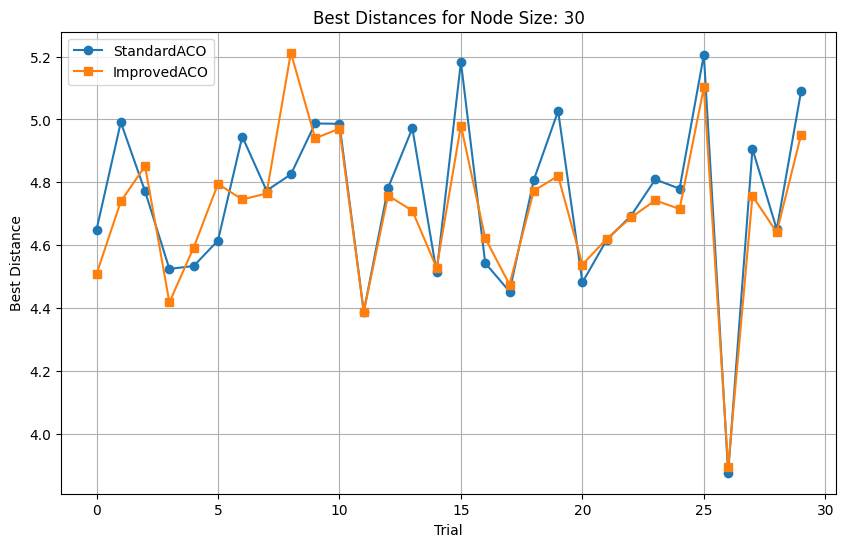


=== Node Size: 35 ===
Generating synthetic data for training...


Generating TSP Solutions: 100%|██████████| 500/500 [11:19<00:00,  1.36s/it]


Training Transformer Model...
Epoch 1/50, Train Loss: 308.1257, Val Loss: 7.0673
Epoch 2/50, Train Loss: 4.6877, Val Loss: 1.9673
Epoch 3/50, Train Loss: 1.2027, Val Loss: 0.3296
Epoch 4/50, Train Loss: 0.4016, Val Loss: 0.0634
Epoch 5/50, Train Loss: 0.2385, Val Loss: 0.0256
Epoch 6/50, Train Loss: 0.1993, Val Loss: 0.0187
Epoch 7/50, Train Loss: 0.1800, Val Loss: 0.0166
Epoch 8/50, Train Loss: 0.1670, Val Loss: 0.0162
Epoch 9/50, Train Loss: 0.1533, Val Loss: 0.0163
Epoch 10/50, Train Loss: 0.1404, Val Loss: 0.0163
Epoch 11/50, Train Loss: 0.1287, Val Loss: 0.0164
Epoch 12/50, Train Loss: 0.1225, Val Loss: 0.0164
Epoch 13/50, Train Loss: 0.1162, Val Loss: 0.0163
Epoch 14/50, Train Loss: 0.1124, Val Loss: 0.0165
Epoch 15/50, Train Loss: 0.1082, Val Loss: 0.0164
Epoch 16/50, Train Loss: 0.1072, Val Loss: 0.0165
Epoch 17/50, Train Loss: 0.1062, Val Loss: 0.0166
Epoch 18/50, Train Loss: 0.1042, Val Loss: 0.0166
Early stopping triggered.
Running 30 trials for node size 35...


Trials for node size 35:   3%|▎         | 1/30 [00:03<01:46,  3.66s/it]

Trial 1: StandardACO Best Distance = 4.5858, ImprovedACO Best Distance = 4.4654


Trials for node size 35:   7%|▋         | 2/30 [00:07<01:43,  3.69s/it]

Trial 2: StandardACO Best Distance = 5.4301, ImprovedACO Best Distance = 5.4564


Trials for node size 35:  10%|█         | 3/30 [00:11<01:39,  3.68s/it]

Trial 3: StandardACO Best Distance = 4.8884, ImprovedACO Best Distance = 4.9219


Trials for node size 35:  13%|█▎        | 4/30 [00:15<01:38,  3.80s/it]

Trial 4: StandardACO Best Distance = 4.8080, ImprovedACO Best Distance = 4.6933


Trials for node size 35:  17%|█▋        | 5/30 [00:18<01:34,  3.77s/it]

Trial 5: StandardACO Best Distance = 5.6620, ImprovedACO Best Distance = 5.5430


Trials for node size 35:  20%|██        | 6/30 [00:22<01:29,  3.74s/it]

Trial 6: StandardACO Best Distance = 4.8809, ImprovedACO Best Distance = 4.8150


Trials for node size 35:  23%|██▎       | 7/30 [00:26<01:26,  3.77s/it]

Trial 7: StandardACO Best Distance = 4.9579, ImprovedACO Best Distance = 4.9257


Trials for node size 35:  27%|██▋       | 8/30 [00:29<01:22,  3.74s/it]

Trial 8: StandardACO Best Distance = 5.3285, ImprovedACO Best Distance = 5.2594


Trials for node size 35:  30%|███       | 9/30 [00:33<01:18,  3.72s/it]

Trial 9: StandardACO Best Distance = 4.4666, ImprovedACO Best Distance = 4.4612


Trials for node size 35:  33%|███▎      | 10/30 [00:37<01:15,  3.78s/it]

Trial 10: StandardACO Best Distance = 5.0402, ImprovedACO Best Distance = 5.2194


Trials for node size 35:  37%|███▋      | 11/30 [00:41<01:11,  3.78s/it]

Trial 11: StandardACO Best Distance = 5.5788, ImprovedACO Best Distance = 5.3960


Trials for node size 35:  40%|████      | 12/30 [00:45<01:07,  3.76s/it]

Trial 12: StandardACO Best Distance = 5.7861, ImprovedACO Best Distance = 5.6012


Trials for node size 35:  43%|████▎     | 13/30 [00:48<01:03,  3.76s/it]

Trial 13: StandardACO Best Distance = 5.0232, ImprovedACO Best Distance = 4.9878


Trials for node size 35:  47%|████▋     | 14/30 [00:52<00:59,  3.73s/it]

Trial 14: StandardACO Best Distance = 4.9430, ImprovedACO Best Distance = 4.8935


Trials for node size 35:  50%|█████     | 15/30 [00:56<00:56,  3.79s/it]

Trial 15: StandardACO Best Distance = 5.1726, ImprovedACO Best Distance = 5.2035


Trials for node size 35:  53%|█████▎    | 16/30 [01:00<00:53,  3.83s/it]

Trial 16: StandardACO Best Distance = 5.1734, ImprovedACO Best Distance = 5.2050


Trials for node size 35:  57%|█████▋    | 17/30 [01:03<00:49,  3.78s/it]

Trial 17: StandardACO Best Distance = 5.3300, ImprovedACO Best Distance = 5.3244


Trials for node size 35:  60%|██████    | 18/30 [01:07<00:44,  3.74s/it]

Trial 18: StandardACO Best Distance = 5.3955, ImprovedACO Best Distance = 5.1773


Trials for node size 35:  63%|██████▎   | 19/30 [01:11<00:40,  3.71s/it]

Trial 19: StandardACO Best Distance = 5.4220, ImprovedACO Best Distance = 5.6117


Trials for node size 35:  67%|██████▋   | 20/30 [01:15<00:38,  3.84s/it]

Trial 20: StandardACO Best Distance = 5.2744, ImprovedACO Best Distance = 4.8949


Trials for node size 35:  70%|███████   | 21/30 [01:19<00:34,  3.82s/it]

Trial 21: StandardACO Best Distance = 5.0303, ImprovedACO Best Distance = 5.0549


Trials for node size 35:  73%|███████▎  | 22/30 [01:22<00:30,  3.77s/it]

Trial 22: StandardACO Best Distance = 5.5019, ImprovedACO Best Distance = 5.2764


Trials for node size 35:  77%|███████▋  | 23/30 [01:26<00:26,  3.76s/it]

Trial 23: StandardACO Best Distance = 4.5980, ImprovedACO Best Distance = 4.6284


Trials for node size 35:  80%|████████  | 24/30 [01:30<00:22,  3.72s/it]

Trial 24: StandardACO Best Distance = 4.9643, ImprovedACO Best Distance = 4.8428


Trials for node size 35:  83%|████████▎ | 25/30 [01:33<00:18,  3.69s/it]

Trial 25: StandardACO Best Distance = 5.1165, ImprovedACO Best Distance = 5.2099


Trials for node size 35:  87%|████████▋ | 26/30 [01:37<00:14,  3.69s/it]

Trial 26: StandardACO Best Distance = 4.7814, ImprovedACO Best Distance = 4.6459


Trials for node size 35:  90%|█████████ | 27/30 [01:41<00:11,  3.69s/it]

Trial 27: StandardACO Best Distance = 5.0319, ImprovedACO Best Distance = 5.2340


Trials for node size 35:  93%|█████████▎| 28/30 [01:44<00:07,  3.68s/it]

Trial 28: StandardACO Best Distance = 5.2188, ImprovedACO Best Distance = 5.1787


Trials for node size 35:  97%|█████████▋| 29/30 [01:48<00:03,  3.75s/it]

Trial 29: StandardACO Best Distance = 5.4120, ImprovedACO Best Distance = 5.2030


Trials for node size 35: 100%|██████████| 30/30 [01:52<00:00,  3.75s/it]

Trial 30: StandardACO Best Distance = 4.9849, ImprovedACO Best Distance = 5.0561


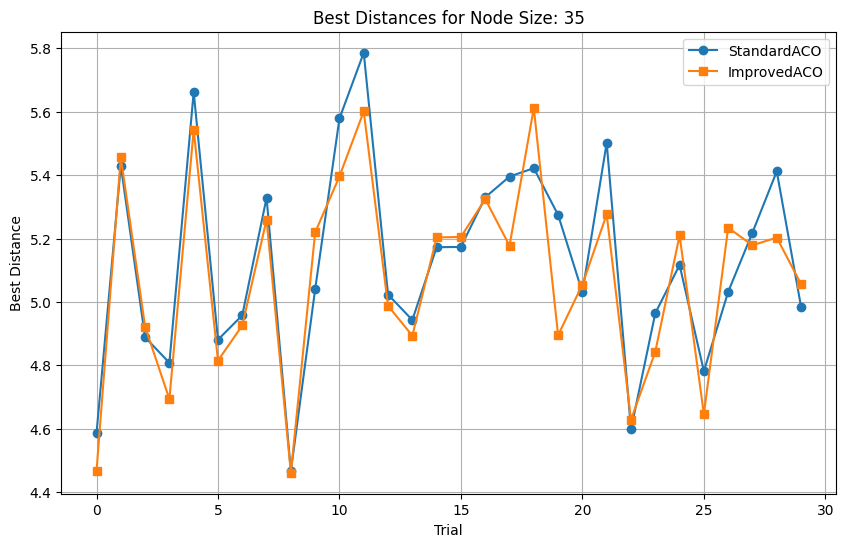


=== Node Size: 40 ===
Generating synthetic data for training...


Generating TSP Solutions: 100%|██████████| 500/500 [13:08<00:00,  1.58s/it]


Training Transformer Model...
Epoch 1/50, Train Loss: 184.1094, Val Loss: 11.8078
Epoch 2/50, Train Loss: 6.5744, Val Loss: 2.0477
Epoch 3/50, Train Loss: 1.1809, Val Loss: 0.2240
Epoch 4/50, Train Loss: 0.3225, Val Loss: 0.0388
Epoch 5/50, Train Loss: 0.2139, Val Loss: 0.0170
Epoch 6/50, Train Loss: 0.1820, Val Loss: 0.0145
Epoch 7/50, Train Loss: 0.1669, Val Loss: 0.0142
Epoch 8/50, Train Loss: 0.1587, Val Loss: 0.0142
Epoch 9/50, Train Loss: 0.1498, Val Loss: 0.0143
Epoch 10/50, Train Loss: 0.1392, Val Loss: 0.0143
Epoch 11/50, Train Loss: 0.1311, Val Loss: 0.0143
Epoch 12/50, Train Loss: 0.1216, Val Loss: 0.0143
Epoch 13/50, Train Loss: 0.1118, Val Loss: 0.0142
Epoch 14/50, Train Loss: 0.1058, Val Loss: 0.0142
Epoch 15/50, Train Loss: 0.1004, Val Loss: 0.0142
Epoch 16/50, Train Loss: 0.0986, Val Loss: 0.0142
Epoch 17/50, Train Loss: 0.0959, Val Loss: 0.0142
Epoch 18/50, Train Loss: 0.0925, Val Loss: 0.0142
Epoch 19/50, Train Loss: 0.0899, Val Loss: 0.0142
Epoch 20/50, Train Loss: 0

Trials for node size 40:   3%|▎         | 1/30 [00:04<02:07,  4.39s/it]

Trial 1: StandardACO Best Distance = 4.5855, ImprovedACO Best Distance = 4.5664


Trials for node size 40:   7%|▋         | 2/30 [00:08<02:01,  4.34s/it]

Trial 2: StandardACO Best Distance = 4.6385, ImprovedACO Best Distance = 4.7423


Trials for node size 40:  10%|█         | 3/30 [00:13<02:01,  4.52s/it]

Trial 3: StandardACO Best Distance = 5.5411, ImprovedACO Best Distance = 5.5660


Trials for node size 40:  13%|█▎        | 4/30 [00:17<01:55,  4.46s/it]

Trial 4: StandardACO Best Distance = 5.7026, ImprovedACO Best Distance = 5.8785


Trials for node size 40:  17%|█▋        | 5/30 [00:22<01:49,  4.38s/it]

Trial 5: StandardACO Best Distance = 5.5940, ImprovedACO Best Distance = 5.8788


Trials for node size 40:  20%|██        | 6/30 [00:26<01:44,  4.35s/it]

Trial 6: StandardACO Best Distance = 5.2246, ImprovedACO Best Distance = 5.0249


Trials for node size 40:  23%|██▎       | 7/30 [00:30<01:39,  4.31s/it]

Trial 7: StandardACO Best Distance = 4.7101, ImprovedACO Best Distance = 5.2338


Trials for node size 40:  27%|██▋       | 8/30 [00:35<01:38,  4.46s/it]

Trial 8: StandardACO Best Distance = 5.5620, ImprovedACO Best Distance = 5.4481


Trials for node size 40:  30%|███       | 9/30 [00:39<01:32,  4.41s/it]

Trial 9: StandardACO Best Distance = 5.4312, ImprovedACO Best Distance = 5.2453


Trials for node size 40:  33%|███▎      | 10/30 [00:43<01:27,  4.37s/it]

Trial 10: StandardACO Best Distance = 6.3415, ImprovedACO Best Distance = 6.3898


Trials for node size 40:  37%|███▋      | 11/30 [00:48<01:23,  4.37s/it]

Trial 11: StandardACO Best Distance = 5.6272, ImprovedACO Best Distance = 5.9100


Trials for node size 40:  40%|████      | 12/30 [00:52<01:18,  4.33s/it]

Trial 12: StandardACO Best Distance = 5.5074, ImprovedACO Best Distance = 5.7314


Trials for node size 40:  43%|████▎     | 13/30 [00:56<01:13,  4.31s/it]

Trial 13: StandardACO Best Distance = 5.2611, ImprovedACO Best Distance = 5.1659


Trials for node size 40:  47%|████▋     | 14/30 [01:01<01:09,  4.35s/it]

Trial 14: StandardACO Best Distance = 5.5732, ImprovedACO Best Distance = 5.6594


Trials for node size 40:  50%|█████     | 15/30 [01:05<01:04,  4.31s/it]

Trial 15: StandardACO Best Distance = 5.2501, ImprovedACO Best Distance = 5.3445


Trials for node size 40:  53%|█████▎    | 16/30 [01:09<00:59,  4.28s/it]

Trial 16: StandardACO Best Distance = 5.7511, ImprovedACO Best Distance = 5.5599


Trials for node size 40:  57%|█████▋    | 17/30 [01:13<00:55,  4.25s/it]

Trial 17: StandardACO Best Distance = 5.4515, ImprovedACO Best Distance = 5.5370


Trials for node size 40:  60%|██████    | 18/30 [01:18<00:50,  4.24s/it]

Trial 18: StandardACO Best Distance = 5.3062, ImprovedACO Best Distance = 4.9992


Trials for node size 40:  63%|██████▎   | 19/30 [01:22<00:46,  4.24s/it]

Trial 19: StandardACO Best Distance = 6.0143, ImprovedACO Best Distance = 5.8127


Trials for node size 40:  67%|██████▋   | 20/30 [01:26<00:42,  4.23s/it]

Trial 20: StandardACO Best Distance = 5.7764, ImprovedACO Best Distance = 5.8119


Trials for node size 40:  70%|███████   | 21/30 [01:30<00:38,  4.24s/it]

Trial 21: StandardACO Best Distance = 5.4098, ImprovedACO Best Distance = 5.3953


Trials for node size 40:  73%|███████▎  | 22/30 [01:35<00:34,  4.25s/it]

Trial 22: StandardACO Best Distance = 5.2079, ImprovedACO Best Distance = 5.2830


Trials for node size 40:  77%|███████▋  | 23/30 [01:39<00:29,  4.24s/it]

Trial 23: StandardACO Best Distance = 4.8997, ImprovedACO Best Distance = 4.9807


Trials for node size 40:  80%|████████  | 24/30 [01:43<00:25,  4.22s/it]

Trial 24: StandardACO Best Distance = 5.6861, ImprovedACO Best Distance = 5.4750


Trials for node size 40:  83%|████████▎ | 25/30 [01:47<00:21,  4.24s/it]

Trial 25: StandardACO Best Distance = 5.4501, ImprovedACO Best Distance = 5.5503


Trials for node size 40:  87%|████████▋ | 26/30 [01:52<00:17,  4.29s/it]

Trial 26: StandardACO Best Distance = 4.9166, ImprovedACO Best Distance = 4.9690


Trials for node size 40:  90%|█████████ | 27/30 [01:56<00:12,  4.31s/it]

Trial 27: StandardACO Best Distance = 5.7512, ImprovedACO Best Distance = 5.5552


Trials for node size 40:  93%|█████████▎| 28/30 [02:00<00:08,  4.28s/it]

Trial 28: StandardACO Best Distance = 5.7046, ImprovedACO Best Distance = 5.6701


Trials for node size 40:  97%|█████████▋| 29/30 [02:04<00:04,  4.26s/it]

Trial 29: StandardACO Best Distance = 5.4144, ImprovedACO Best Distance = 5.4263


Trials for node size 40: 100%|██████████| 30/30 [02:09<00:00,  4.30s/it]

Trial 30: StandardACO Best Distance = 5.1295, ImprovedACO Best Distance = 4.8967


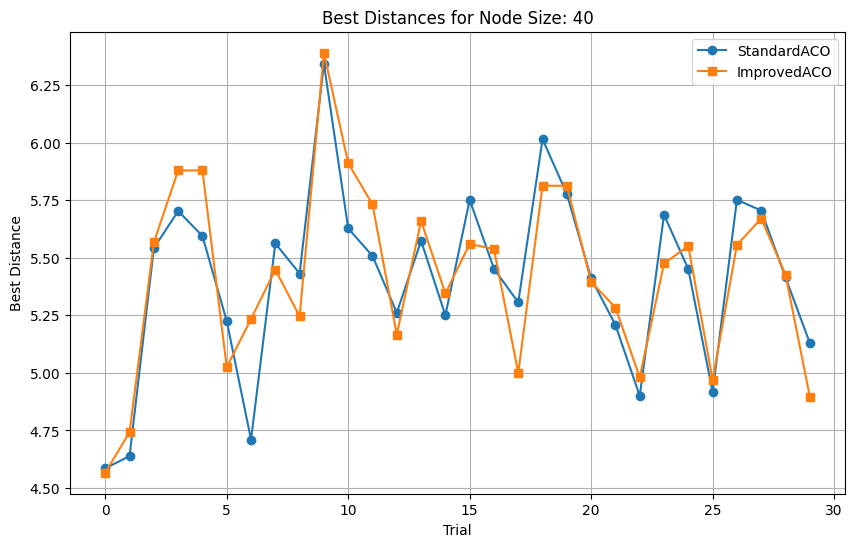


=== Statistical Significance Testing ===
Node Size 30: p-value = 6.0565e-02
Node Size 35: p-value = 5.2263e-02
Node Size 40: p-value = 8.8719e-01


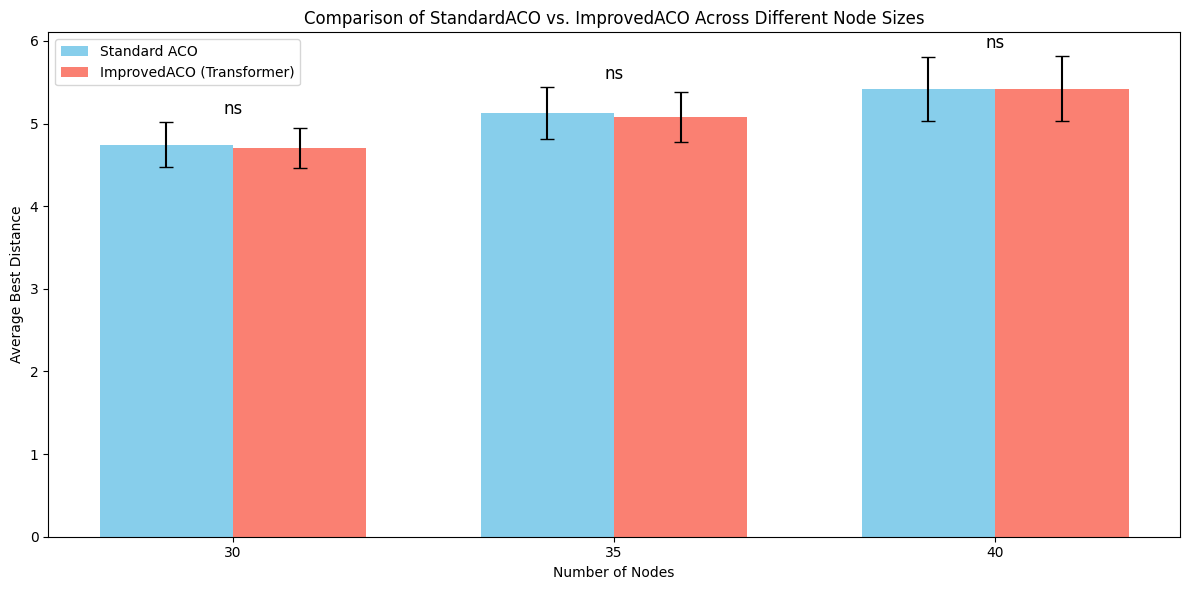

In [35]:
node_sizes = [30, 35, 40]

num_trials = 30
iterations = 50
num_ants = 20
alpha = 1.0
beta = 2.0
evaporation_rate = 0.5
Q = 100

results = run_experiment(
    node_sizes=node_sizes,
    num_trials=num_trials,
    iterations=iterations,
    num_ants=num_ants,
    alpha=alpha,
    beta=beta,
    evaporation_rate=evaporation_rate,
    Q=Q
)

print("\n=== Statistical Significance Testing ===")
p_values = perform_statistical_tests(results)

plot_results(results, p_values)
